# Overview
- MNIST dataset
  + Goal: recognizing handwritten digits
  + Input: a 28x28 image
  + Output: class label (0, 1,..., 9)
- Defining an CNN+MLP for MNIST
- Training and evaluating an CNN+MLP

# Import libraries

In [1]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import SGD

from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model

import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_classes = 10   # 10 classes: 0, 1,..., 9

# (1) Data

In [3]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
60000 train samples
10000 test samples


# (2) Declare model

In [4]:
# 28x28 MNIST image
input_image = Input(shape=(28, 28, 1), name='Input')

# conv, pooling layers + dropout
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv1')(input_image)
x = MaxPooling2D(pool_size=(2, 2), name='pool1')(x)
x = Dropout(rate=0.2, name='conv_dropout1')(x)

x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv2')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool2')(x)
x = Dropout(rate=0.2, name='conv_dropout2')(x)

x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv3')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool3')(x)
x = Dropout(rate=0.2, name='conv_dropout3')(x)

# similar to the MLP example!
# matrix ---> vector
x = Flatten(name='flatten')(x)

# FC layers + dropout
x = Dense(units=512, activation='relu', name='fc1')(x)
x = Dropout(rate=0.2, name='fc_dropout1')(x)

x = Dense(units=512, activation='relu', name='fc2')(x)
x = Dropout(rate=0.2, name='fc_dropout2')(x)

output_label = Dense(units=num_classes, activation='softmax', name='fc3_10ways_softmax')(x)

# define model
model = Model(inputs=input_image, outputs=output_label, name='mnist_mlp')

# print model summary
model.summary()

Model: "mnist_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dropout1 (Dropout)              │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dropout2 (Dropout)              │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 7, 7, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dropout3 (Dropout)              │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 512)                 │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_dropout1 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc2 (Dense)                          │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_dropout2 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc3_10ways_softmax (Dense)           │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,817,610 (6.93 MB)

 Trainable params: 1,817,610 (6.93 MB)

 Non-trainable params: 0 (0.00 B)

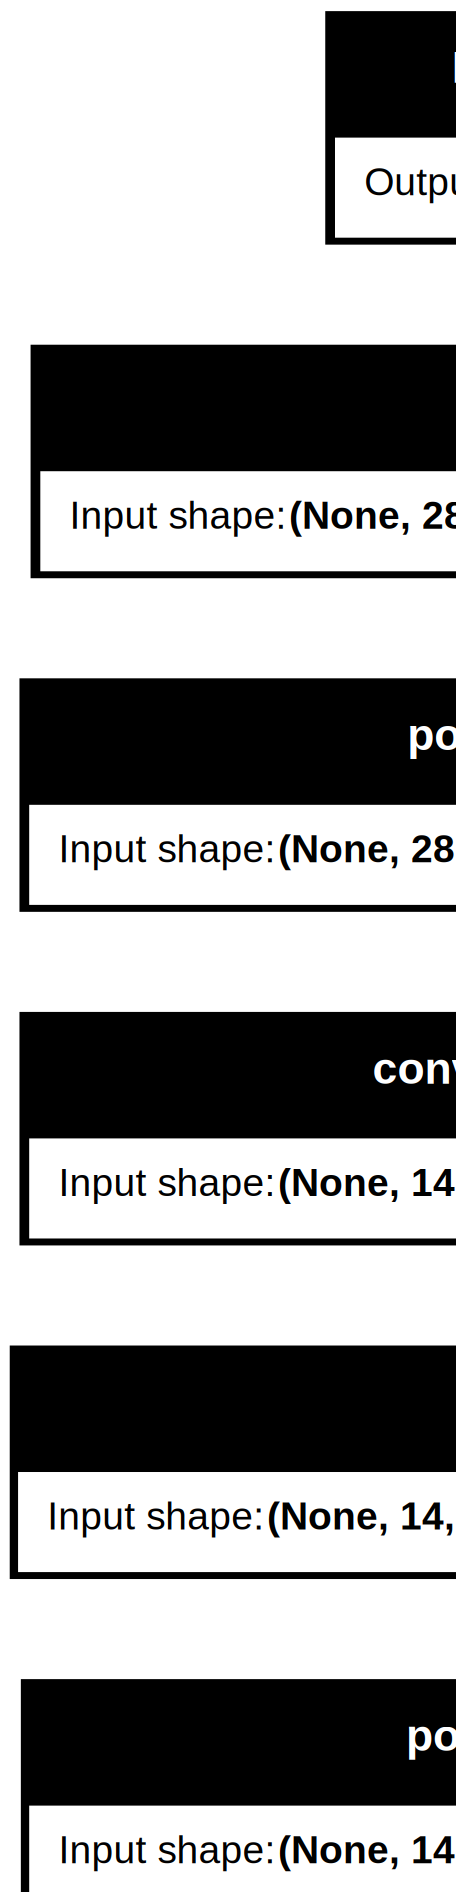

In [5]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# (3) Train defined model
- Note that the training history including loss and accuracy will be save in 'history' variable
- In case your system runs out of memory (OOM), try to decrease batch size

In [6]:
# declare learning rate, loss function, and model metric
loss = 'categorical_crossentropy'
learning_rate = 0.01
model.compile(loss=loss, optimizer=SGD(learning_rate=learning_rate), metrics=['accuracy'])

# train the model
batch_size = 128
epochs = 30

starting_time = time.time()
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batch_size,
                    epochs=epochs)
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.1893 - loss: 2.2709 - val_accuracy: 0.6651 - val_loss: 1.2974
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6265 - loss: 1.1047 - val_accuracy: 0.8953 - val_loss: 0.3562
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8424 - loss: 0.4859 - val_accuracy: 0.9376 - val_loss: 0.2084
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8991 - loss: 0.3192 - val_accuracy: 0.9546 - val_loss: 0.1447
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9216 - loss: 0.2456 - val_accuracy: 0.9605 - val_loss: 0.1193
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9363 - loss: 0.2051 - val_accuracy: 0.9648 - val_loss: 0.1055
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9415 - loss: 0.1815 - val_accuracy: 0.9696 - val_loss: 0.0917
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9484 - loss: 0.1629 - val_accuracy: 

### Training time
- Training time with GTX 1080 is about 4.2231 minutes for 30 epochs
- Training time with Core i7 is around 105.5 minutes for 30 epochs

# (4) Evaluate trained model

In [7]:
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9866 - loss: 0.0425
Test loss: 0.03464802727103233
Test accuracy: 0.9884999990463257


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


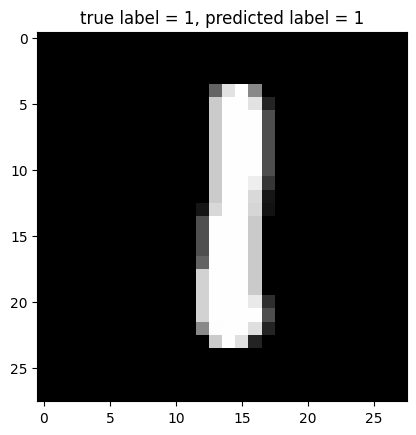

In [8]:
# select a test image randomly
random_test_index = np.random.choice(x_test.shape[0], size=1)[0]
test_img = x_test[random_test_index]
test_label = np.argmax(y_test[random_test_index])

# predict test image with trained model
pred_label = model.predict(np.expand_dims(test_img, axis=0))
pred_label = np.argmax(pred_label)

plt.imshow(test_img[:, :, 0], cmap='gray')
plt.title('true label = %d, predicted label = %d' % (test_label, pred_label))
plt.show()